In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import numpy as np
import sigpy as sp
import sigpy.plot as pl
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import scikit_posthocs as sp

import sys
sys.path.append("/home/ahannum/Documents/Phase/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
import seaborn as sns

In [2]:
from scipy.signal import argrelextrema
def get_bound(vector):
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,3), dpi=500)
    plot1=sns.histplot(np.reshape(vector[0],128*128),bins=20,kde=True,
                 stat = 'probability',binrange = [-math.pi,math.pi],ax = axes[0])
    
    plot2=sns.histplot(np.reshape(vector[1],128*128),bins=20,kde=True,
                 stat = 'probability',binrange = [-math.pi,math.pi],ax = axes[1])
    
    #plt.show() 
    plt.close(fig)  

    xx = plot1.get_lines()[0].get_xdata()
    
    yy = plot1.get_lines()[0].get_ydata()
    #print(np.unique(vector[1][~np.isnan(vector[0])]))
    
    
    minima = argrelextrema(yy,np.less)

    if minima[0].size >0:
        thresh_min_x = xx[minima[0][0]]
        if minima[0].shape[0] ==1:
            if xx[minima[0][0]]<0:
                thresh_min_x = xx[minima[0][0]]
                thresh_max_x = math.pi
            elif xx[minima[0][0]]>0:
                thresh_min_x = -math.pi
                thresh_max_x = xx[minima[0][0]]

        else:
            thresh_max_x = xx[minima[0][-1]]
    else:
        thresh_min_x = -math.pi
        thresh_max_x = math.pi
   
    xx = plot2.get_lines()[0].get_xdata()
    yy = plot2.get_lines()[0].get_ydata()
    minima = argrelextrema(yy,np.less)
    if minima[0].size >0:
        thresh_min_y = xx[minima[0][0]]
        if minima[0].shape[0] ==1:
            if xx[minima[0][0]]<0:
                thresh_min_y = xx[minima[0][0]]
                thresh_max_y = math.pi
            elif xx[minima[0][0]]>0:
                thresh_min_y = -math.pi
                thresh_max_y = xx[minima[0][0]]

        else:
            thresh_max_y = xx[minima[0][-1]]
    else:
        thresh_min_y = -math.pi
        thresh_max_y = math.pi
    #print('Thresh Min X',thresh_min_x,'Thresh Max X', thresh_max_x)
    #print('Thresh Min Y',thresh_min_y,'Thresh Max Y',thresh_max_y)

    if thresh_min_y > 0:
        thresh_min_y = -math.pi

    if thresh_min_x > 0:
        thresh_min_x = -math.pi

    if thresh_max_x < 0:
        thresh_min_x = math.pi
    
    if thresh_max_y < 0:
        thresh_min_y = math.pi
    
    index = np.argwhere(~np.isnan(vector[0]))
    for ii in range(index.shape[0]):
        idx = index[ii,0]
        idy = index[ii,1]
        if vector[0][idx,idy] > thresh_max_x:
            vector[0][idx,idy] -= math.pi
        
        if vector[0][idx,idy] < thresh_min_x:
            vector[0][idx,idy] += math.pi
            
        if vector[1][idx,idy] > thresh_max_y:
            vector[1][idx,idy] -= math.pi
        
        if vector[1][idx,idy] < thresh_min_y:
            vector[1][idx,idy] += math.pi
    
    del plot1,plot2,fig
    return vector
        
def calc_atten(vgrad_slope):   
    spins = 1000
    atten = vgrad_slope.copy()
    index = np.argwhere(~np.isnan(vgrad_slope))
    for ii in range(index.shape[0]):
        idx = index[ii,0]
        idy = index[ii,1]
        maxslope = vgrad_slope[idx,idy]
        
        phase = np.linspace(0,maxslope,spins)
        atten[idx,idy] = abs(np.sum(np.exp(1j*phase))/spins)
    
    return atten

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx


def main_bgphs(base,mask):
    vgrad = np.gradient(base)*mask
    og = vgrad
    vgrad = get_bound(vgrad.copy())
    vgrad_slope = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
    atten = calc_atten(vgrad_slope)
    #im_corrected = (mag)/(atten)
    return_grad = vgrad
    del vgrad
    return [return_grad,vgrad_slope]

In [3]:
import concurrent.futures
import logging
import threading
import time
import nibabel as nib
import random
from scipy.io import savemat

def metrics(num):

    print('starting',num)
    volunteers=[1,2,3,4,5,7,8,9,10,11]
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + str(volunteers[num])
    data,affine, voxsize = load_nifti(os.path.join(inpath, 'M2_registered_all.nii'), return_voxsize=True)
    phs = np.angle(data)
    M0_adj = np.exp(1j*phs)/np.nanmean(np.exp(1j*phs[:,:,:,0,:]),axis = -1)[:,:,:,np.newaxis,np.newaxis]
    #M0_adj = np.angle(data)
    
    mask = mask,header =  nrrd.read(os.path.join(inpath, 'M2_mask_new.nrrd'))
    mask = mask.astype('float')
    mask[mask ==0] = np.nan

    M0_slope = np.zeros((2,128,128,6,4,40))
    for sl in range(6):
        for diff in range(4):
            for rep in range(40):
                base =np.angle(M0_adj[:,:,sl,diff,rep])
                #mag=np.abs(M0_adj[:,:,sl,diff,rep,td]) 
                [grad,slope] =  main_bgphs(base,mask[:,:,sl])
                M0_slope[:,:,:,sl,diff,rep] = grad
        print('Slice',sl)
                   
    savename = os.path.join(inpath, 'M2_spatial_slope.npy')
    np.save(savename,M0_slope)
    
    del M0_slope
    print('Finished std',num)
    return num


with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(metrics,ii) for ii in range(10)]

    for future in concurrent.futures.as_completed(futures):
        print(future.result())
        #output.append(future.result())
        


starting 0
starting 1
starting 2
starting 3
starting 4
Slice 0
Slice 0
Slice 0
Slice 0
Slice 0
Slice 1
Slice 1
Slice 1
Slice 1
Slice 1
Slice 2
Slice 2
Slice 2
Slice 2
Slice 2
Slice 3
Slice 3
Slice 3
Slice 3
Slice 3
Slice 4
Slice 4
Slice 5
Finished std 4
starting 45

Slice 4
Slice 4
Slice 5
Finished std 3
starting 6
3
Slice 0
Slice 4
Slice 5
Finished std 2
starting 7
2
Slice 5
Finished std 1
starting 8
1
Slice 0
Slice 0
Slice 1
Slice 5
Finished std 0
starting 9
0
Slice 0
Slice 1
Slice 0
Slice 1
Slice 1
Slice 1
Slice 2
Slice 2
Slice 2
Slice 2
Slice 2
Slice 3
Slice 3
Slice 3
Slice 3
Slice 4
Slice 4
Slice 3
Slice 4
Slice 5
Finished std 5
5
Slice 5
Finished std 7
7
Slice 5
Finished std 6
6
Slice 4
Slice 4
Slice 5
Finished std 9
9
Slice 5
Finished std 8
8


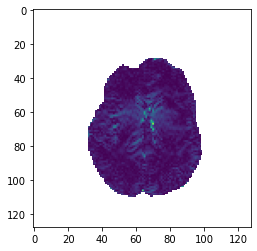

# Actual Bosotrapping 

In [29]:
def diffusion_bootstrap(iterations, repetitions):
    ########## Import modules #####################################################################################################################
    import numpy as np                                                                                                 # Import numpy module
    import random  
    import itertools                                                                                                  # Import random module
    import random

    ########## Store Combinations Information#######3 ############################################################################################
    combos = (list(itertools.combinations(np.arange(40),r=repetitions)))
    selection = random.sample(list(np.arange(len(combos))),iterations)
    select_idx = [combos[i] for i in selection]
    
    return select_idx


#Revised Background phase removal 
import concurrent.futures
import logging
import threading
import time
import nibabel as nib
from scipy.io import savemat

def metrics(num):
    iterations = 1000
    repetitions = 5
    idx = diffusion_bootstrap(iterations, repetitions)

    print('starting',num)
    volunteers=[1,2,3,4,5,7,8,9,10,11]
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + str(volunteers[num])

    loadname = os.path.join(inpath, 'M2_spatial_slope.npy')
    data = np.load(loadname)
    slope = np.sqrt(data[0,:,:,:,:,:]**2+data[1,:,:,:,:,:]**2)[:,:,:,:,idx]
    del data
    
    
    savename = os.path.join(inpath, 'M2_spatial_stdavg_boostrap.npz')
    M0_std = np.nanstd(slope,axis = -1)
    M0_avg = np.nanmean(slope,axis = -1)
    print(M0_std.shape)
    np.savez(savename,avg=M0_avg,std = M0_std)

    del M0_std,M0_avg
    print('Finished std',num)
    return num



with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(metrics,ii) for ii in range(10)]

    for future in concurrent.futures.as_completed(futures):
        print(future.result())
        #output.append(future.result())
        


starting 0
starting 1
starting 3startingstarting 2

 4


<ipython-input-29-d0bbbc0df46c>:41: RuntimeWarning: Mean of empty slice
  M0_avg = np.nanmean(slope,axis = -1)


(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
Finished std 4
4
starting 5
Finished std 3
3
starting 6
Finished std 1
1
starting 7
Finished std 2
2
starting 8
Finished std 0
0
starting 9
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
Finished std 5
5
Finished std 6
6
Finished std 7
7
Finished std 9
9
Finished std 8
8


# Boostrap Metrics

In [3]:
def ci95(im):
    sort_im = np.sort(im,axis = (-1))
    lb_idx = round(sort_im.shape[-1]*0.05)
    lb = sort_im[:,:,lb_idx]
    ub_idx = round(sort_im.shape[-1]*0.95)
    ub = sort_im[:,:,ub_idx]
    med_im = np.nanmedian(sort_im,axis = -1)
    mean_im = np.nanmean(sort_im,axis = -1)
    std_im = np.nanstd(sort_im,axis = -1)

    return med_im,lb,ub,mean_im


    

# Load in Mask & Magnitude image
def get_metric_std(vv):
    print('starting',vv)
    volunteers=[1,2,3,4,5,7,8,9,10,11]
    volunteer = str(volunteers[vv])
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + volunteer 
    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])

    num = 0
    for num in range(3):
        mask_end   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
        mask_end.sort()
        mask_end,header =  nrrd.read(os.path.join(inpath, mask_end[num]))
        mask = mask_end
        mask = mask.astype('float')
        mask[mask==0] = np.nan
        if num ==0:
            M0_mask = mask
        if num ==1:
            M1_mask = mask
        if num ==2:
            M2_mask = mask


    savename = os.path.join(inpath,'M0_spatial_stdavg_boostrap.npz')
    M0_std = np.load(savename)['std']
    
    savename = os.path.join(inpath,'M1_spatial_stdavg_boostrap.npz')
    M1_std = np.load(savename)['std']

    savename = os.path.join(inpath,'M2_spatial_stdavg_boostrap.npz')
    M2_std = np.load(savename)['std']

    med_m0 = np.zeros((128,128,6,4))
    lb_ub_m0 = np.zeros((2,128,128,6,4))
    mean_m0 = np.zeros((128,128,6,4))
    std_m0 = np.zeros((2,128,128,6,4))

    med_m1 = np.zeros((128,128,6,4))
    lb_ub_m1 = np.zeros((2,128,128,6,4))
    mean_m1 = np.zeros((128,128,6,4))
    std_m1 = np.zeros((2,128,128,6,4))

    med_m2 = np.zeros((128,128,6,4))
    lb_ub_m2 = np.zeros((2,128,128,6,4))
    mean_m2= np.zeros((128,128,6,4))
    std_m2 = np.zeros((2,128,128,6,4))
    print(M0_std.shape)

    for dd in range(4):
        for sl in range(6):
       
            ###############################################################################################
            im = (M0_std[:,:,sl,dd,:]) * M0_mask[:,:,sl][:,:,np.newaxis]
            med_m0[:,:,sl,dd], lb_ub_m0[0,:,:,sl,dd] ,lb_ub_m0[1,:,:,sl,dd],mean_m0[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

            im = (M1_std[:,:,sl,dd,:]) * M1_mask[:,:,sl][:,:,np.newaxis]
            med_m1[:,:,sl,dd], lb_ub_m1[0,:,:,sl,dd] ,lb_ub_m1[1,:,:,sl,dd],mean_m1[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

            im = (M2_std[:,:,sl,dd,:]) * M2_mask[:,:,sl][:,:,np.newaxis]
            med_m2[:,:,sl,dd], lb_ub_m2[0,:,:,sl,dd] ,lb_ub_m2[1,:,:,sl,dd],mean_m2[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

    
    savename = os.path.join(inpath,'M0_spatial_std_boostrap_analysis.npz')
    np.savez(savename, med= med_m0, lb_ub = lb_ub_m0,avg = mean_m0)

    savename = os.path.join(inpath,'M1_spatial_std_boostrap_analysis.npz')
    np.savez(savename, med= med_m1, lb_ub = lb_ub_m1,avg = mean_m1)

    savename = os.path.join(inpath,'M2_spatial_std_boostrap_analysis.npz')
    np.savez(savename, med= med_m2, lb_ub = lb_ub_m2,avg = mean_m2)

    print('finished',vv)


   

In [4]:
# Difference metric 
import concurrent.futures
import logging
import threading
import time
import nibabel as nib

# Register all repetitions and directions together for either M0, M1, M2 all volunteers 
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    futures = [executor.submit(get_metric_std,num) for num in range(10)]
    for future in concurrent.futures.as_completed(futures):
        print(future.result())

starting 0
starting 1
starting 2
(128, 128, 6, 4, 1000)


/home/ahannum/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


(128, 128, 6, 4, 1000)


<ipython-input-3-e9003ed2405c>:8: RuntimeWarning: Mean of empty slice
  mean_im = np.nanmean(sort_im,axis = -1)
/home/ahannum/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(128, 128, 6, 4, 1000)
finished 2
startingNone
 3
finished 0
starting 4
None
finished 1
starting 5
None
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
finished 3
starting 6
None
finished 4
startingNone 7

finished 5
startingNone 8

(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
finished 6
starting 9
None
finished 7
None
finished 8
None
(128, 128, 6, 4, 1000)
finished 9
None


In [25]:
test=slope[:,:,:,:,idx]

In [5]:
def ci95(im):
    sort_im = np.sort(im,axis = (-1))
    lb_idx = round(sort_im.shape[-1]*0.05)
    lb = sort_im[:,:,lb_idx]
    ub_idx = round(sort_im.shape[-1]*0.95)
    ub = sort_im[:,:,ub_idx]
    med_im = np.nanmedian(sort_im,axis = -1)
    mean_im = np.nanmean(sort_im,axis = -1)
    std_im = np.nanstd(sort_im,axis = -1)

    return med_im,lb,ub,mean_im


    

# Load in Mask & Magnitude image
def get_metric_std(vv):
    print('starting',vv)
    volunteers=[1,2,3,4,5,7,8,9,10,11]
    volunteer = str(volunteers[vv])
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + volunteer 
    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])

    num = 0
    for num in range(3):
        mask_end   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
        mask_end.sort()
        mask_end,header =  nrrd.read(os.path.join(inpath, mask_end[num]))
        mask = mask_end
        mask = mask.astype('float')
        mask[mask==0] = np.nan
        if num ==0:
            M0_mask = mask
        if num ==1:
            M1_mask = mask
        if num ==2:
            M2_mask = mask


    savename = os.path.join(inpath,'M0_spatial_stdavg_boostrap.npz')
    M0_std = np.load(savename)['avg']
    
    savename = os.path.join(inpath,'M1_spatial_stdavg_boostrap.npz')
    M1_std = np.load(savename)['avg']

    savename = os.path.join(inpath,'M2_spatial_stdavg_boostrap.npz')
    M2_std = np.load(savename)['avg']

    med_m0 = np.zeros((128,128,6,4))
    lb_ub_m0 = np.zeros((2,128,128,6,4))
    mean_m0 = np.zeros((128,128,6,4))
    std_m0 = np.zeros((2,128,128,6,4))

    med_m1 = np.zeros((128,128,6,4))
    lb_ub_m1 = np.zeros((2,128,128,6,4))
    mean_m1 = np.zeros((128,128,6,4))
    std_m1 = np.zeros((2,128,128,6,4))

    med_m2 = np.zeros((128,128,6,4))
    lb_ub_m2 = np.zeros((2,128,128,6,4))
    mean_m2= np.zeros((128,128,6,4))
    std_m2 = np.zeros((2,128,128,6,4))
    print(M0_std.shape)

    for dd in range(4):
        for sl in range(6):
       
            ###############################################################################################
            im = (M0_std[:,:,sl,dd,:]) * M0_mask[:,:,sl][:,:,np.newaxis]
            med_m0[:,:,sl,dd], lb_ub_m0[0,:,:,sl,dd] ,lb_ub_m0[1,:,:,sl,dd],mean_m0[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

            im = (M1_std[:,:,sl,dd,:]) * M1_mask[:,:,sl][:,:,np.newaxis]
            med_m1[:,:,sl,dd], lb_ub_m1[0,:,:,sl,dd] ,lb_ub_m1[1,:,:,sl,dd],mean_m1[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

            im = (M2_std[:,:,sl,dd,:]) * M2_mask[:,:,sl][:,:,np.newaxis]
            med_m2[:,:,sl,dd], lb_ub_m2[0,:,:,sl,dd] ,lb_ub_m2[1,:,:,sl,dd],mean_m2[:,:,sl,dd] = ci95(np.reshape(im,(128,128,1000)))
            

    
    savename = os.path.join(inpath,'M0_spatial_avg_boostrap_analysis.npz')
    np.savez(savename, med= med_m0, lb_ub = lb_ub_m0,avg = mean_m0)

    savename = os.path.join(inpath,'M1_spatial_avg_boostrap_analysis.npz')
    np.savez(savename, med= med_m1, lb_ub = lb_ub_m1,avg = mean_m1)

    savename = os.path.join(inpath,'M2_spatial_avg_boostrap_analysis.npz')
    np.savez(savename, med= med_m2, lb_ub = lb_ub_m2,avg = mean_m2)

    print('finished',vv)


   

In [6]:
# Difference metric 
import concurrent.futures
import logging
import threading
import time
import nibabel as nib

# Register all repetitions and directions together for either M0, M1, M2 all volunteers 
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    futures = [executor.submit(get_metric_std,num) for num in range(10)]
    for future in concurrent.futures.as_completed(futures):
        print(future.result())

starting 0
starting 1starting 2

(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)


<ipython-input-5-623fc23c1674>:8: RuntimeWarning: Mean of empty slice
  mean_im = np.nanmean(sort_im,axis = -1)


finished 1
starting None3

finished 0
starting 4
None
finished 2
startingNone 5

(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
finished 4
startingNone 6

finished 3
startingNone
 7
finished 5
starting 8None

(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
(128, 128, 6, 4, 1000)
finished 7
starting 9
None
finished 6
None
finished 8
None
(128, 128, 6, 4, 1000)
finished 9
None


starting 0


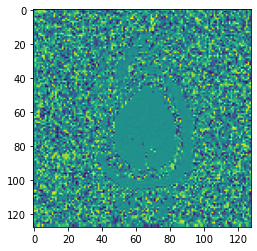

starting 1


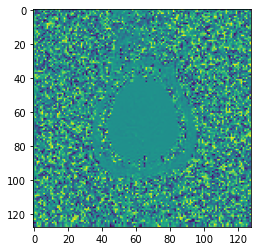

starting 2


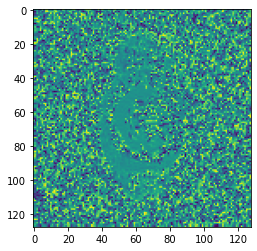

starting 3


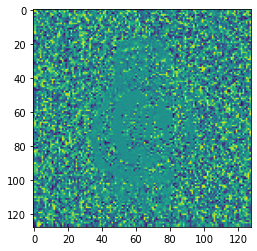

starting 4


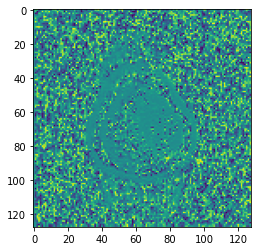

starting 5


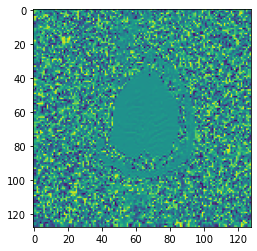

starting 6


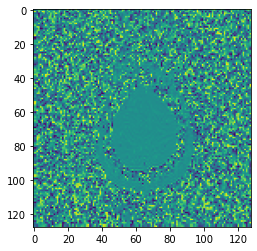

starting 7


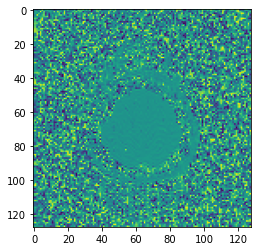

starting 8


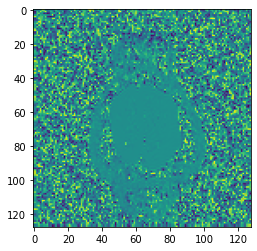

starting 9


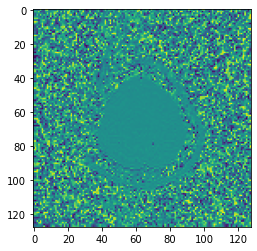

In [6]:
for num in range(10):

    print('starting',num)
    volunteers=[1,2,3,4,5,7,8,9,10,11]
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + str(volunteers[num])
    data,affine, voxsize = load_nifti(os.path.join(inpath, 'M2_registered_all.nii'), return_voxsize=True)
    phs = np.angle(data)
    M0_adj = np.exp(1j*phs)/np.nanmean(np.exp(1j*phs[:,:,:,0,:]),axis = -1)[:,:,:,np.newaxis,np.newaxis]
    plt.imshow(np.angle(M0_adj[:,:,-1,0,0]))
    plt.show()